<h2>Investigating PyMC's A/B Testing</h2>
On the web site for PyMC they give example code for A/B testing analyzing revenue. They do something very unusual there: the summarize the data as 1) record count 2) number of purchases 3) total revenue. Nopthing about variation. This wasn't making a lot of sense to me, so I decided to run it with the data simulated as my old company. I'm still workong on analyzing the results. <br>
<br>
I did't set it up to run 200 or so trials as the other workbooks here, but running it once demonstrates the issues. One can run it a bunch of times; which side wins changes but consistently one side wins.

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

import math as m
from scipy import stats
from scipy.stats import gennorm
from scipy.stats import gamma

from scipy.stats import bernoulli, expon

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
)

In [3]:
@dataclass
class GammaPrior:
    alpha: float
    beta: float

In [4]:
@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float

In [5]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

In [6]:
@dataclass
class BinomialData:
    trials: int
    successes: int

The key may be modifying this bit here, but there prior is basically a hurdle model with Gamma non-zero revenue, which should be good enough.

In [7]:
class RevenueModel:
    def __init__(self, conversion_rate_prior: BetaPrior, mean_purchase_prior: GammaPrior):
        self.conversion_rate_prior = conversion_rate_prior
        self.mean_purchase_prior = mean_purchase_prior

    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        total_revenue = [d.total_revenue for d in data]

        with pm.Model() as model:
            theta = pm.Beta(
                "theta",
                alpha=self.conversion_rate_prior.alpha,
                beta=self.conversion_rate_prior.beta,
                shape=num_variants,
            )
            lam = pm.Gamma(
                "lam",
                alpha=self.mean_purchase_prior.alpha,
                beta=self.mean_purchase_prior.beta,
                shape=num_variants,
            )
            converted = pm.Binomial(
                "converted", n=visitors, p=theta, observed=purchased, shape=num_variants
            )
            revenue = pm.Gamma(
                "revenue", alpha=purchased, beta=lam, observed=total_revenue, shape=num_variants
            )
            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (1 / lam))
            theta_reluplift = []
            reciprocal_lam_reluplift = []
            reluplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison_theta = theta[0]
                    comparison_lam = 1 / lam[0]
                    comparison_rpv = revenue_per_visitor[0]
                elif comparison_method == "best_of_rest":
                    others_theta = [theta[j] for j in range(num_variants) if j != i]
                    others_lam = [1 / lam[j] for j in range(num_variants) if j != i]
                    others_rpv = [revenue_per_visitor[j] for j in range(num_variants) if j != i]
                    if len(others_rpv) > 1:
                        comparison_theta = pm.math.maximum(*others_theta)
                        comparison_lam = pm.math.maximum(*others_lam)
                        comparison_rpv = pm.math.maximum(*others_rpv)
                    else:
                        comparison_theta = others_theta[0]
                        comparison_lam = others_lam[0]
                        comparison_rpv = others_rpv[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                theta_reluplift.append(
                    pm.Deterministic(f"theta_reluplift_{i}", theta[i] / comparison_theta - 1)
                )
                reciprocal_lam_reluplift.append(
                    pm.Deterministic(
                        f"reciprocal_lam_reluplift_{i}", (1 / lam[i]) / comparison_lam - 1
                    )
                )
                reluplift.append(
                    pm.Deterministic(f"reluplift_{i}", revenue_per_visitor[i] / comparison_rpv - 1)
                )
        return model

In [8]:
c_prior = BetaPrior(alpha=5000, beta=5000)
mp_prior = GammaPrior(alpha=9000, beta=900)

In [9]:
data = [
    RevenueData(visitors=1, purchased=1, total_revenue=1),
    RevenueData(visitors=1, purchased=1, total_revenue=1),
]

In [10]:
with RevenueModel(c_prior, mp_prior).create_model(data, "best_of_rest"):
    revenue_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [converted, lam, revenue, theta]


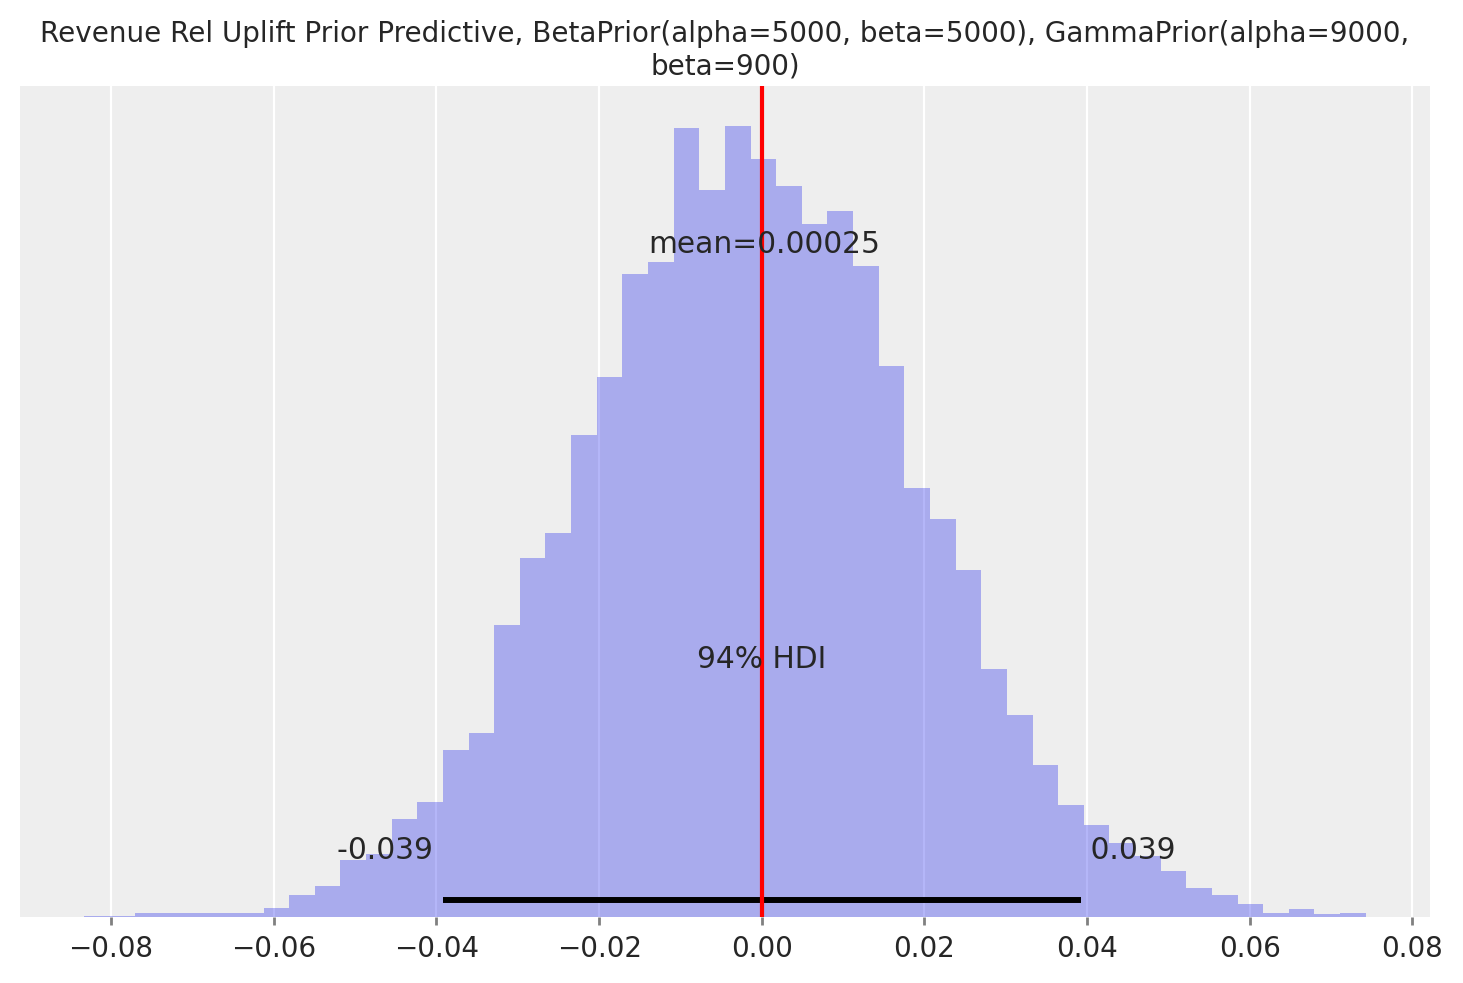

In [11]:
fig, ax = plt.subplots()
az.plot_posterior(revenue_prior_predictive["reluplift_1"], ax=ax, **plotting_defaults)
ax.set_title(f"Revenue Rel Uplift Prior Predictive, {c_prior}, {mp_prior}", fontsize=10)
ax.axvline(x=0, color="red");

In [12]:
dataCount=48000
dataRates=0.60
gGaussMean = 3
gGaussSpread=5
dataMeans=np.exp(gGaussMean)
dataLift=1.05

In [13]:
def generate_revenue_data(N=48000, R=0.60 , M=3, S=2.5, B=3,lift=1.00):
    first_col = np.random.choice(['A', 'B'], size=N)
    second_col = np.zeros(N)
    third_col = np.zeros(N)
    non_zero_count = int((1 - R) * N)
    non_zero_indices = np.random.choice(N, size=non_zero_count, replace=False)
    random_values = gennorm.rvs(beta=B, loc=M, scale=S, size=non_zero_count)
    second_col[non_zero_indices] = np.exp(random_values)
    
    df = pd.DataFrame({
        'TestControl': first_col,
        'Revenue': second_col
    })
    df['Revenue']=df.apply(lambda x: x['Revenue']*lift if x['TestControl']=='B' else x['Revenue'],axis=1)
    df['Purchases'] = df.apply(lambda x: 1 if x['Revenue']>0 else 0,axis=1)

    summary = {
        'visitors': df.groupby('TestControl').size(),
        'purchased': df.groupby('TestControl')['Purchases'].sum(),
        'total_revenue': df.groupby('TestControl')['Revenue'].sum()
    }

    agg = pd.DataFrame(summary).T

    return agg

In [14]:
def run_scenario_value(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
    conversion_rate_prior: BetaPrior,
    mean_purchase_prior: GammaPrior,
    comparison_method: str,
) -> az.InferenceData:
    generated = generate_revenue_data(
        N=dataCount,
        R=dataRates,
        M=gGaussMean,
        S=gGaussSpread,
        lift=dataLift   
    )
    data = [RevenueData(**generated[v].to_dict()) for v in variants]
    with RevenueModel(conversion_rate_prior, mean_purchase_prior).create_model(
        data, comparison_method
    ):
        trace = pm.sample(draws=5000, chains=2, cores=1)

    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f"reluplift_{i}"], ax=axs[i], **plotting_defaults)
        true_rpv = true_conversion_rates[i] * true_mean_purchase[i]
        axs[i].set_title(f"Rel Uplift {variant}, True RPV = {true_rpv:.2f}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {conversion_rate_prior}, {mean_purchase_prior}")

    return trace

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


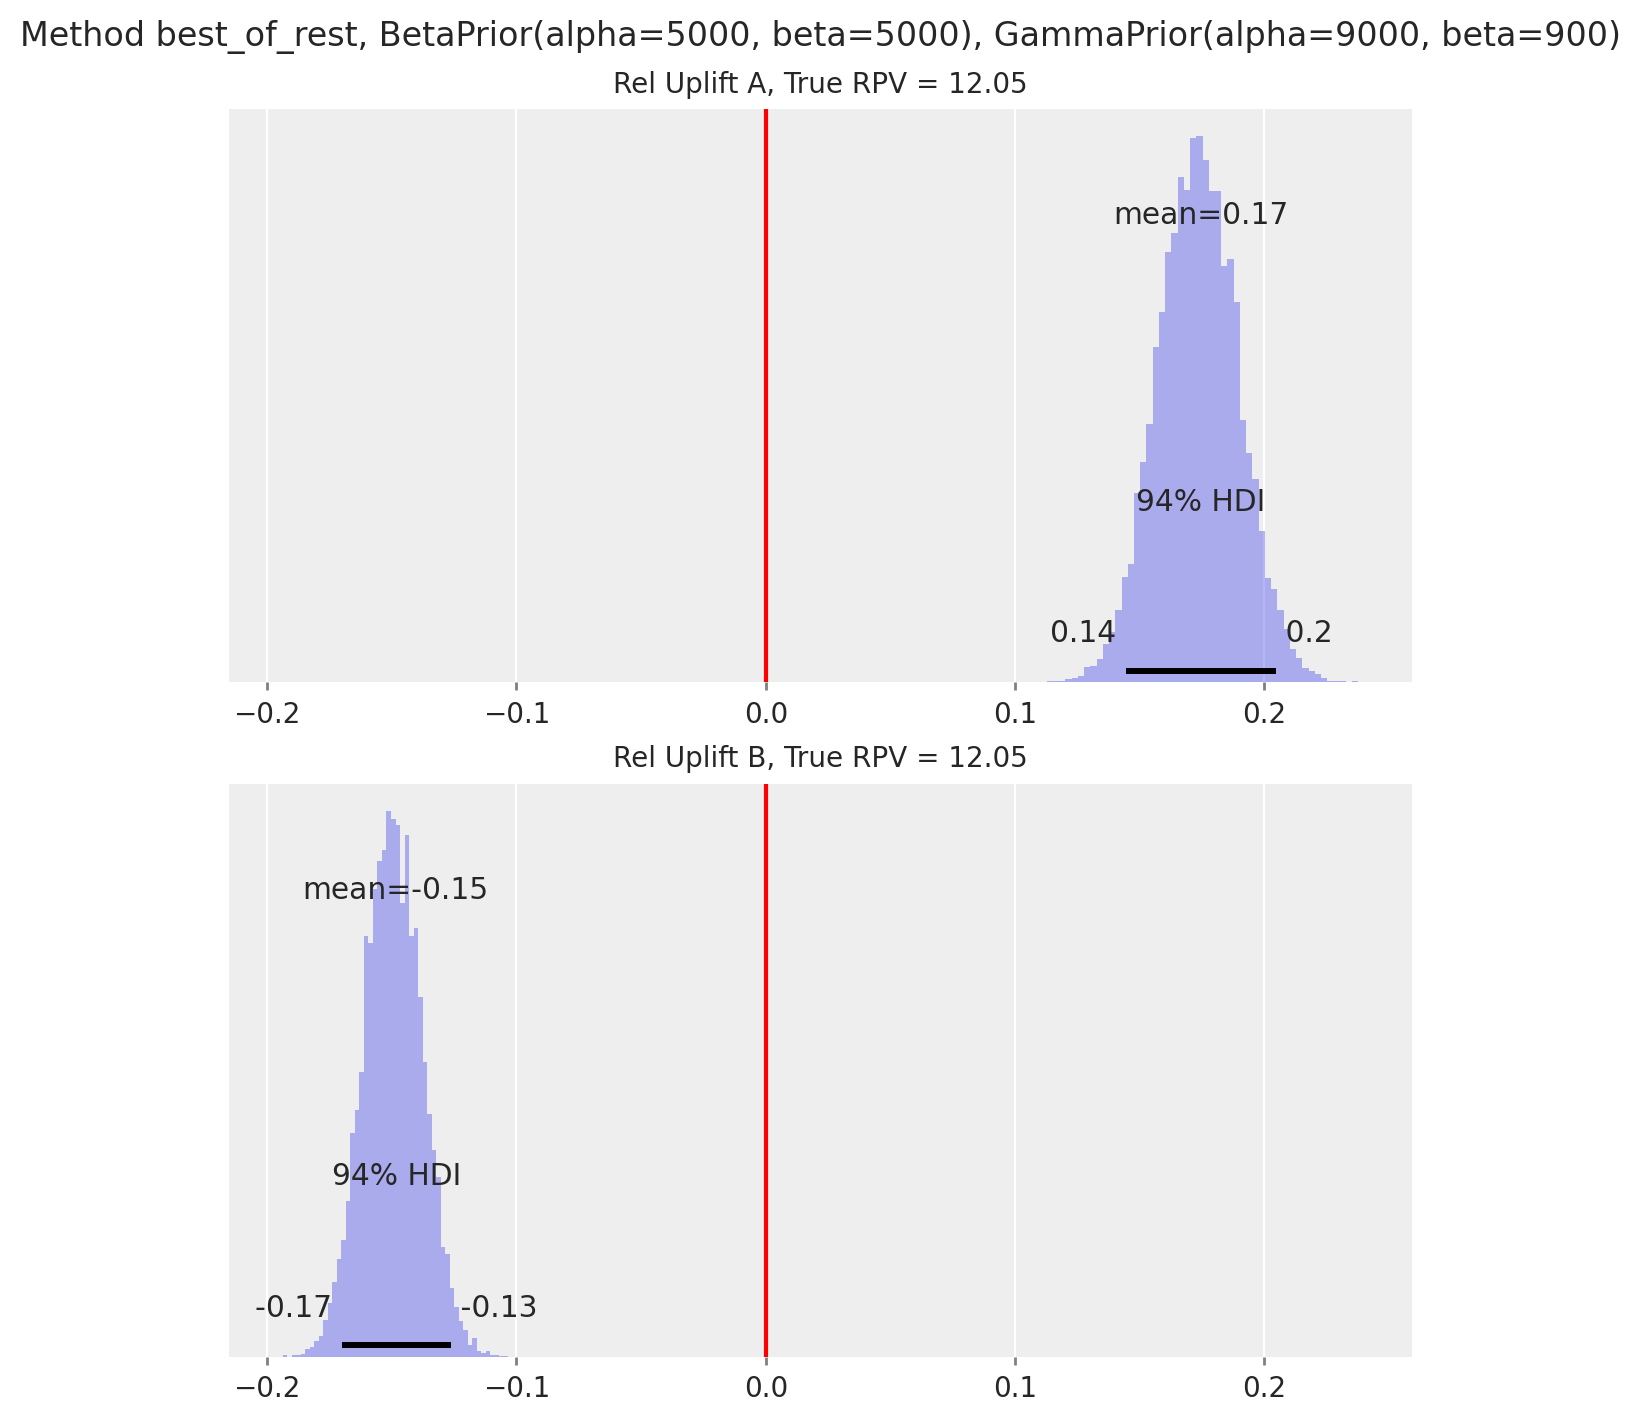

In [15]:

traceOutput = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[dataRates, dataRates],
    true_mean_purchase=[dataMeans, dataMeans],
    samples_per_variant=dataCount/2,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method="best_of_rest",
)